# ETC Core Algorithm

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import desietc.calculator
import desietc.simulate
import desietc.plots

## Examples

Simulate some examples with constant true signal and background rates to demonstrate how GFA and SC inputs are propagated to continuously updated exposure time and SNR estimates.

In [3]:
def etc_study(snr_goal, texp_goal, rho, s0err, b0err, alpha_err, beta_err,
              sprior=1., bprior=1., seed=123, plot_calc=None):
    
    gen = np.random.RandomState(seed=seed)
    (calc, tnow, snr_actual, snr_true, telapsed,
     tremaining, snr_range)= desietc.simulate.simulate_exposure(
        snr_goal, texp_goal, rho, s0err, b0err, alpha_err, beta_err,
        sprior, bprior, estimate_snr=True, gen=gen)
    
    print('Actual SNR', snr_actual)
    print('Actual texp', tnow - calc.t0)
    
    if plot_calc:
        desietc.plots.plot_calculator(calc, tnow, save=plot_calc)
        plt.show()
        plt.clf()

    tfill = np.concatenate([telapsed, telapsed[::-1]])
    snrfill = np.concatenate([snr_range[:,0], snr_range[::-1,1]])
    
    fig = plt.figure(figsize=(8, 5))
    
    plt.plot(telapsed, tremaining, 'k.-', label='Est. Time Remaining')
    plt.ylim(0., 1.15 * texp_goal)
    plt.legend(loc='upper left')
    plt.xlabel('Elapsed Time [s]')
    plt.ylabel('Estimated Time Remaining [s]')
    
    rhs = plt.twinx()
    rhs.fill(tfill, snrfill, alpha=.25, fc='b', ec='None', label='Estimated SNR')
    rhs.plot(calc.dt_pred, snr_true, 'r-', label='True SNR')
    rhs.axhline(snr_goal, c='r', ls='--')
    rhs.axvline(texp_goal, c='r', ls='--')
    rhs.axvline(tnow, c='b', ls=':')
    rhs.set_ylabel('Integrated SNR')
    rhs.set_ylim(0., 1.15 * snr_goal)
    
    plt.xlim(0., 1.15 * texp_goal)
    plt.legend(loc='upper center')
    plt.tight_layout()
    
    return calc

Simulate the best case where the prior matches the true signal and background rates:

Actual SNR 7.0564422362185555
Actual texp 1524.29106801
saving to calc0.png


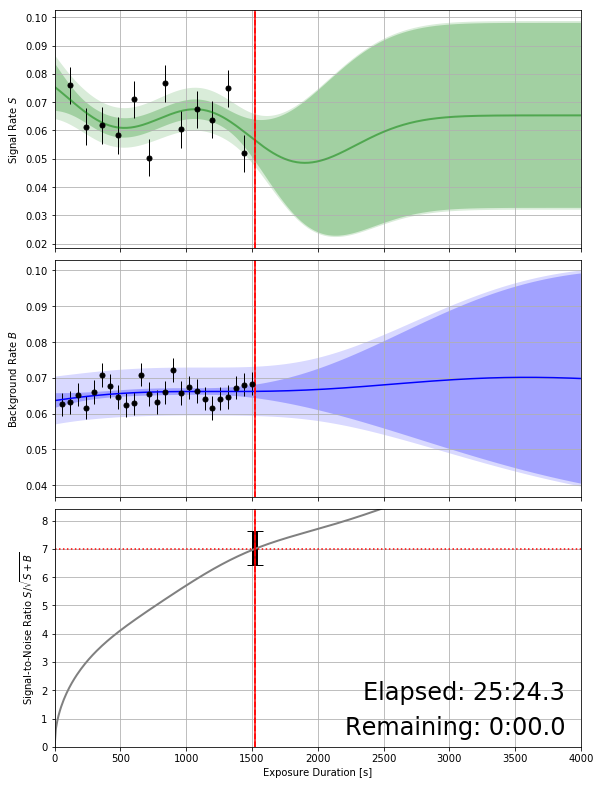

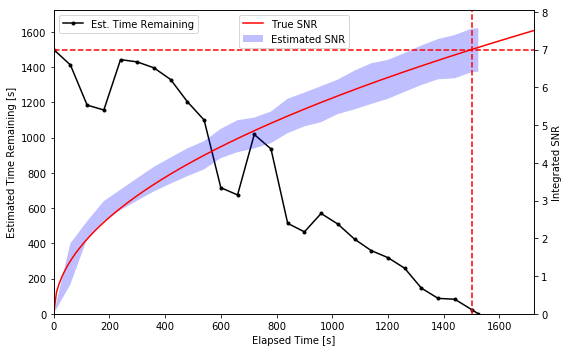

In [4]:
etc_study(snr_goal=7, texp_goal=1500, rho=1, s0err=0.1, b0err=0.05,
          alpha_err=0.1, beta_err=0.1, seed=1, plot_calc='calc0.png');
plt.savefig('demo0.png')

Simulate with a baseline signal rate that is 50% too high, leading to initial exposure-time forecasts that are too short:

Actual SNR 7.0306476638655395
Actual texp 1513.16703754
saving to calc1.png


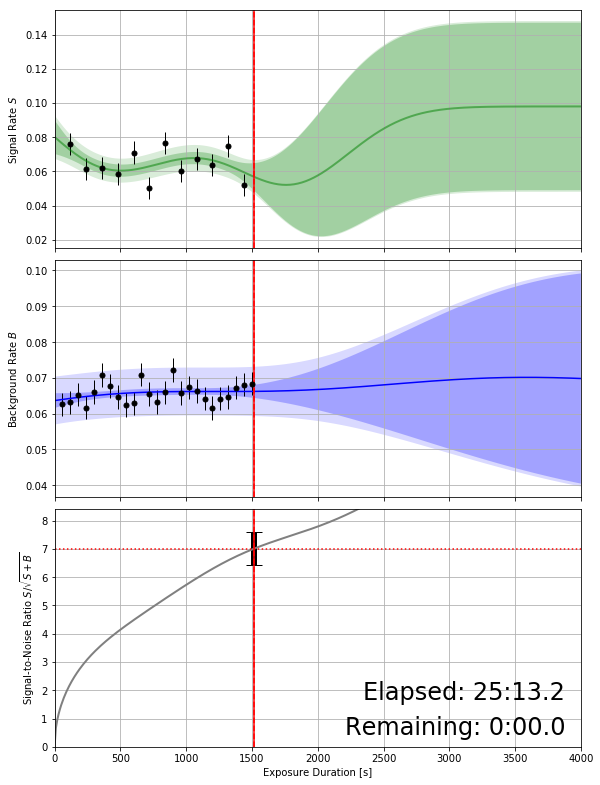

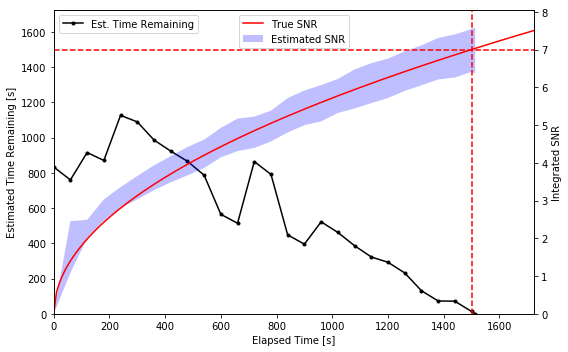

In [5]:
etc_study(snr_goal=7, texp_goal=1500, rho=1, s0err=0.1, b0err=0.05,
          alpha_err=0.1, beta_err=0.1, sprior=1.5, seed=1, plot_calc='calc1.png');
plt.savefig('demo1.png')

Simulate with a baseline background rate that is 50% too high, leading to initial exposure-time forecasts that are too long:

Actual SNR 7.128930952287983
Actual texp 1555.76891983
saving to calc2.png


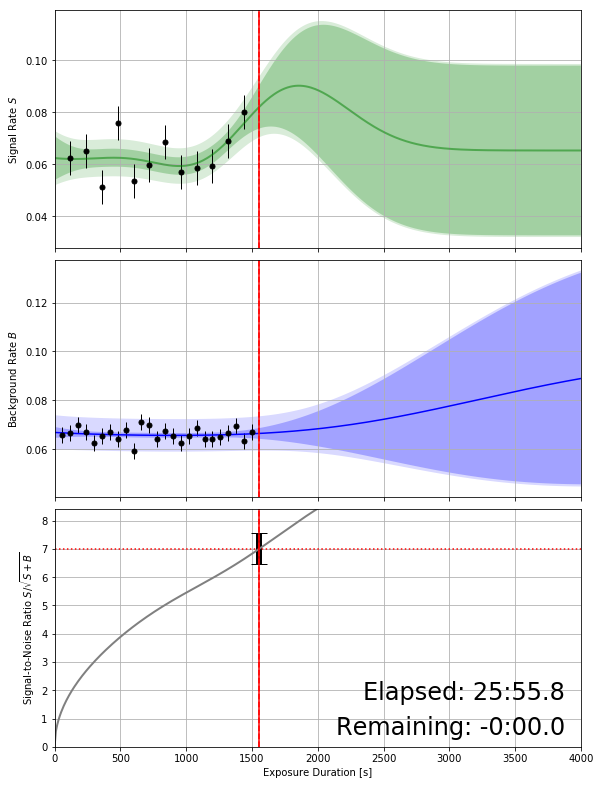

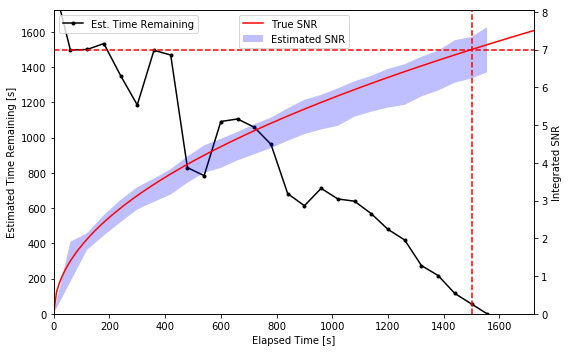

In [6]:
etc_study(snr_goal=7, texp_goal=1500, rho=1, s0err=0.1, b0err=0.05,
          alpha_err=0.1, beta_err=0.1, bprior=1.5, seed=2, plot_calc='calc2.png');
plt.savefig('demo2.png')

## ETC Performance Forecasts

Run many (2K) simulations with different GFA and SC measurement noise realizations, to calculate the distribution of expected integrated SNR for a fixed target (SNR=7).

In [12]:
def error_study(snr_goal, texp_goal, rho, s0err, b0err, alpha_err, beta_err,
                sprior=1., bprior=1., nrepeat=2000, seed=123):
    gen = np.random.RandomState(seed=seed)
    snr, texp = [], []
    for i in range(nrepeat):
        (calc, tnow, snr_actual, snr_true, telapsed,
         tremaining, snr_range)= desietc.simulate.simulate_exposure(
            snr_goal, texp_goal, rho, s0err, b0err, alpha_err, beta_err,
            sprior, bprior, estimate_snr=False, gen=gen)
        snr.append(snr_actual)
        texp.append(tnow - calc.t0)
    snr = np.array(snr)
    texp = np.array(texp)
    return snr, snr_goal

Plot the results of an `error_study` run:

In [13]:
def dsnr_hist(snr, snr_goal, win=9.5, save=None):
    # Calculate statistics.
    dsnr = 1e2* (snr  - snr_goal) / snr_goal
    med = np.median(dsnr)
    std = np.std(dsnr)
    lo, hi = np.percentile(dsnr, (15.865, 84.135))

    fig = plt.figure(figsize=(8, 5))
    plt.hist(dsnr, range=(-win, +win), bins=25, histtype='stepfilled',
             fc='red', ec='k')
    plt.axvline(med, c='k', ls='--')
    plt.axvline(lo, c='k', ls=':')
    plt.axvline(hi, c='k', ls=':')
    plt.xlabel('(SNR(actual) - SNR(goal)) / SNR(goal) [%]', fontsize='x-large')
    plt.ylabel('Simulated Exposures', fontsize='x-large')
    
    def label(y, txt):
        xy = (0.97, y)
        plt.annotate(txt, xy, xy, 'axes fraction', 'axes fraction',
                     horizontalalignment='right', fontsize=14)
        
    label(0.9, '[{:+.1f},{:+.1f}]%'.format(lo, hi))
    label(0.8, 'Median {:+.2f}%'.format(med))
    label(0.7, 'RMS {:.1f}%'.format(std))
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

Simulate the best case where the prior matches the true signal and background rates:

In [15]:
snr0, snr_goal = error_study(
    snr_goal=7, texp_goal=1500, rho=1, s0err=0.1, b0err=0.05,
    alpha_err=0.1, beta_err=0.1, sprior=1., bprior=1.)

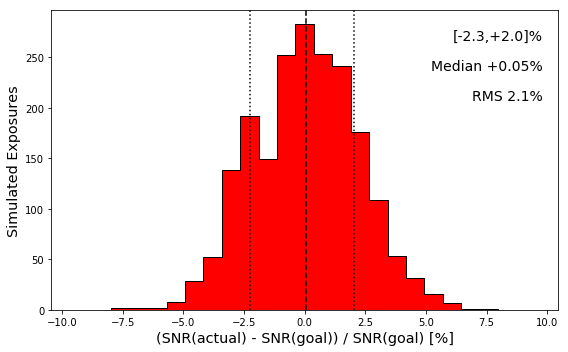

In [16]:
dsnr_hist(snr0, snr_goal, save='dsnr0.png')

Simulate with a baseline signal rate that is 50% too high, leading to initial exposure-time forecasts that are too short:

In [17]:
snr1, snr_goal = error_study(
    snr_goal=7, texp_goal=1500, rho=1, s0err=0.1, b0err=0.05,
    alpha_err=0.1, beta_err=0.1, sprior=1.5, bprior=1.)

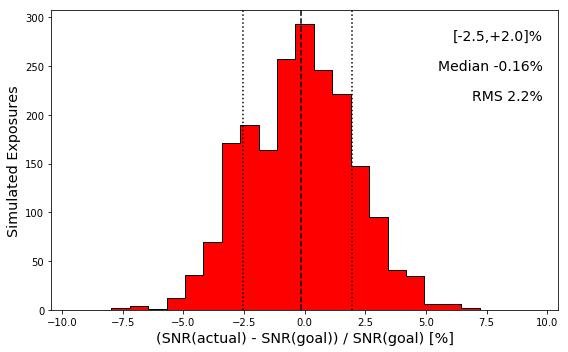

In [18]:
dsnr_hist(snr1, snr_goal, save='dsnr1.png')

Simulate with a baseline background rate that is 50% too high, leading to initial exposure-time forecasts that are too long:

In [19]:
snr2, snr_goal = error_study(
    snr_goal=7, texp_goal=1500, rho=1, s0err=0.1, b0err=0.05,
    alpha_err=0.1, beta_err=0.1, sprior=1., bprior=1.5)

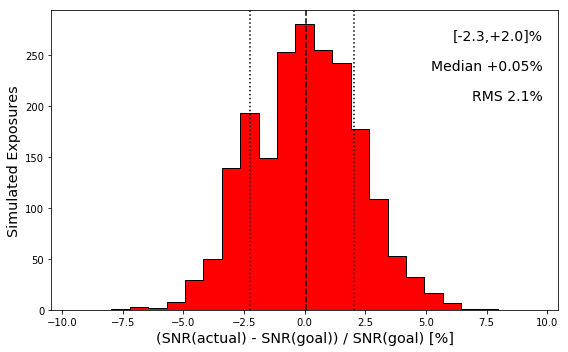

In [20]:
dsnr_hist(snr2, snr_goal, save='dsnr2.png')